In [2]:
! pip install pymc3

Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.6/872.6 kB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 43.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 13.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 12.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.7 MB/s eta 0:00:00
  Crea

In [4]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# 假设我们有一些历史数据
history_time = np.arange(0, 10)  # 历史时间点
history_cost = np.array([80, 75, 72, 69, 68, 66, 67, 70, 74, 78])  # 历史成本
history_price = np.array([120, 118, 115, 110, 105, 100, 95, 90, 88, 85])  # 历史价格

# 定义未来时间
future_time = np.arange(0, 10)

# PyMC v4 模型
with pm.Model() as model:
    # 成本的先验：二次曲线（先降后升）
    alpha_cost = pm.Normal('alpha_cost', mu=0, sigma=10)  # 二次项
    beta_cost = pm.Normal('beta_cost', mu=0, sigma=10)  # 线性项
    gamma_cost = pm.Normal('gamma_cost', mu=70, sigma=10)  # 截距项，表示最低点大约在 70

    # 价格的先验：线性递减
    alpha_price = pm.Normal('alpha_price', mu=-5, sigma=2)  # 线性斜率
    beta_price = pm.Normal('beta_price', mu=120, sigma=10)  # 截距，初始价格

    # 成本模型
    cost_pred = alpha_cost * history_time**2 + beta_cost * history_time + gamma_cost
    # 价格模型
    price_pred = alpha_price * history_time + beta_price

    # 观察数据（历史数据作为观测值）
    cost_obs = pm.Normal('cost_obs', mu=cost_pred, sigma=5, observed=history_cost)
    price_obs = pm.Normal('price_obs', mu=price_pred, sigma=5, observed=history_price)

    # 定义未来的成本和价格预测为 Deterministic 变量
    future_cost_pred = pm.Deterministic('future_cost_pred', alpha_cost * future_time**2 + beta_cost * future_time + gamma_cost)
    future_price_pred = pm.Deterministic('future_price_pred', alpha_price * future_time + beta_price)

    # 后验采样
    trace = pm.sample(2000)




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_cost, beta_cost, gamma_cost, alpha_price, beta_price]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


In [2]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Sampling: [cost_obs, price_obs]


Output()

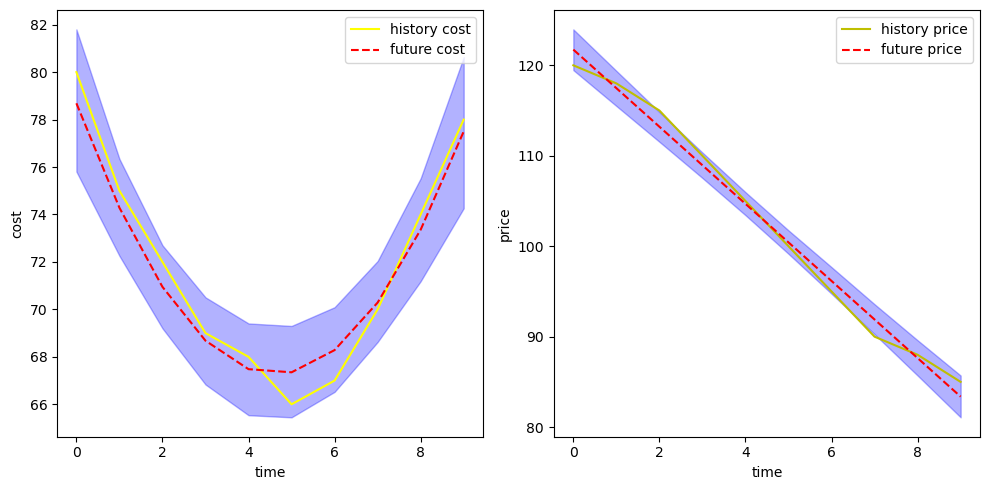

In [6]:
# 使用采样结果来预测未来
with model:
    # 获取未来的预测分布
    posterior_predictive = pm.sample_posterior_predictive(trace)

    # 提取未来的预测数据（从trace中提取）
    future_cost_samples = trace['posterior']['future_cost_pred']
    future_price_samples = trace['posterior']['future_price_pred']

# 预测结果可视化
plt.figure(figsize=(10, 5))

# 画出成本的预测
plt.subplot(1, 2, 1)
plt.plot(history_time, history_cost, 'yellow', label='history cost')
plt.plot(future_time, future_cost_samples.mean(axis=0).mean(axis = 0), 'r--', label='future cost')
plt.fill_between(future_time, 
                 np.percentile(future_cost_samples.mean(axis = 0), 5, axis=0), 
                 np.percentile(future_cost_samples.mean(axis = 0), 95, axis=0), 
                 color='blue', alpha=0.3)
plt.xlabel('time')
plt.ylabel('cost')
plt.legend()

# 画出价格的预测
plt.subplot(1, 2, 2)
plt.plot(history_time, history_price, 'y', label='history price')
plt.plot(future_time, future_price_samples.mean(axis=0).mean(axis = 0), 'r--', label='future price')
plt.fill_between(future_time, 
                 np.percentile(future_price_samples.mean(axis = 0), 5, axis=0), 
                 np.percentile(future_price_samples.mean(axis = 0), 95, axis=0), 
                 color='blue', alpha=0.3)
plt.xlabel('time')
plt.ylabel('price')
plt.legend()

plt.tight_layout()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, beta_global, alpha_0, beta_0, alpha_1, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


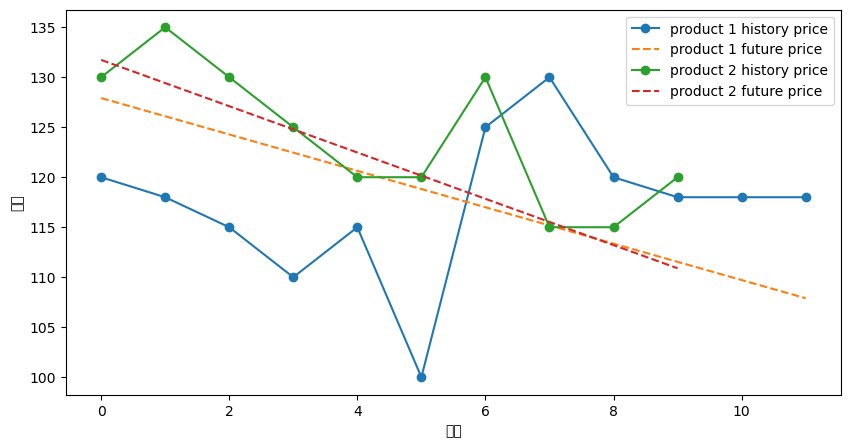

In [13]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# 假设有两个产品的历史时间和价格记录
history_time_1 = np.arange(0, 12)  # 产品1的时间点
history_price_1 = np.array([120, 118, 115, 110, 115, 100, 125, 130, 120, 118, 118, 118])  # 产品1的价格

history_time_2 = np.arange(0, 10)  # 产品2的时间点
history_price_2 = np.array([130, 135, 130, 125, 120, 120, 130, 115, 115, 120])  # 产品2的价格

# 将不同产品的时间和价格数据存入列表
history_times = [history_time_1, history_time_2]
history_prices = [history_price_1, history_price_2]

# PyMC 分层贝叶斯模型
with pm.Model() as model:
    # 全局先验: 所有产品共享的线性模型先验
    alpha_global = pm.Normal('alpha_global', mu=-3, sigma=2)  # 全局斜率的先验
    beta_global = pm.Normal('beta_global', mu=120, sigma=10)  # 全局截距的先验

    # 为每个产品定义局部参数
    alphas = []  # 每个产品的局部斜率
    betas = []   # 每个产品的局部截距
    for i, (times, prices) in enumerate(zip(history_times, history_prices)):
        alpha_i = pm.Normal(f'alpha_{i}', mu=alpha_global, sigma=1)  # 每个产品的局部斜率
        beta_i = pm.Normal(f'beta_{i}', mu=beta_global, sigma=5)     # 每个产品的局部截距
        alphas.append(alpha_i)
        betas.append(beta_i)

        # 产品 i 的价格预测
        price_pred = alpha_i * times + beta_i
        # 观测噪声：较大的噪声可以减小数据对模型的影响
        price_obs = pm.Normal(f'price_obs_{i}', mu=price_pred, sigma=15, observed=prices)

    # 后验采样
    trace = pm.sample(2000)

# 可视化结果
plt.figure(figsize=(10, 5))

for i, (times, prices) in enumerate(zip(history_times, history_prices)):
    alpha_samples = trace['posterior'][f'alpha_{i}'].values.flatten()
    beta_samples = trace['posterior'][f'beta_{i}'].values.flatten()

    # 计算预测的均值
    predicted_prices_mean = np.mean(alpha_samples[:, None] * times + beta_samples[:, None], axis=0)

    # 画出历史价格和拟合的预测结果
    plt.plot(times, prices, 'o-', label=f'product {i+1} history price')
    plt.plot(times, predicted_prices_mean, '--', label=f'product {i+1} future price')

plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.show()


In [8]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
trace['posterior'][f'alpha_{0}'].values.shape

(4, 2000)

In [14]:
! pwd

/Users/tangning/Desktop/DTM/lifecycle_features


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('./../Dataset/latex_pillow.csv')
df = df[df['Sales_volume'] != 0]
df = df.dropna()
df

,Month,Unit_price,Sales_volume,Revenue,Cost,Promotion_expense,Profit,Version,Unit_cost,ROI,Profit_rate,Target
0,9,231.022793,8599.0,1.986565e+06,513463.73,2.979848e+05,1.175117e+06,1.0,59.712028,1.448171,0.591532,22031.0
1,10,228.190640,22031.0,5.027268e+06,1296847.55,7.540902e+05,2.976330e+06,1.0,58.864670,1.451205,0.592037,57819.0
2,11,235.609903,57819.0,1.362273e+07,3466877.14,2.043409e+06,8.112443e+06,1.0,59.960863,1.472236,0.595508,34354.0
3,12,232.228445,34354.0,7.977976e+06,2038590.83,1.196696e+06,4.742689e+06,1.0,59.340712,1.465925,0.594473,20282.0
4,1,101.821270,20282.0,2.065139e+06,1170602.10,3.097708e+05,5.847661e+05,1.0,57.716305,0.395013,0.283161,51821.0
...,...,...,...,...,...,...,...,...,...,...,...,...
81,6,95.717707,3620.0,3.464981e+05,158197.14,5.197471e+04,1.363262e+05,4.0,43.700867,0.648642,0.393440,2407.0
82,7,92.408766,2407.0,2.224279e+05,119451.71,3.336418e+04,6.961201e+04,4.0,49.626801,0.455529,0.312964,2368.0
83,8,99.675908,2368.0,2.360325e+05,130987.47,3.540488e+04,6.964020e+04,4.0,55.315655,0.418530,0.295045,3459.0
84,9,91.487771,3459.0,3.164562e+05,164136.12,4.746843e+04,1.048516e+05,4.0,47.451899,0.495508,0.331331,2572.0


In [24]:
version2 = df[df['Version'] == 2]
version2['Unit_price'].values


array([123.91701137, 122.82736629, 113.31224963, 111.67599691,
       121.48030185, 121.69909175, 123.88180472, 122.92087785,
       113.44698994, 127.80032001, 127.12794118, 135.80814605])

In [28]:
version3 = df[df['Version'] == 3]
version3['Unit_price'].values
np.mean(version3['Unit_price'].values)


103.2168385081817

In [33]:
version3['Unit_price'].values[:9]

array([136.54532247, 136.01043554, 115.5625149 , 112.42755047,
        71.85146911,  64.0012287 ,  65.36715241,  69.49832794,
        80.39936158])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, beta_global, alpha_0, beta_0, alpha_1, beta_1]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/tangning/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


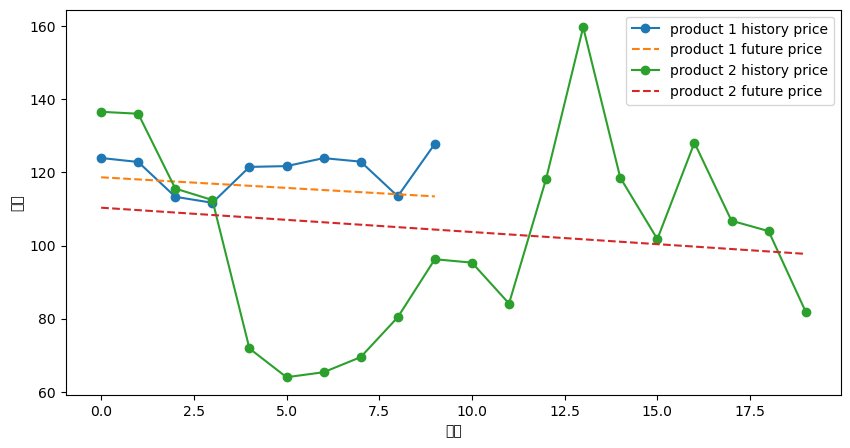

In [34]:
# 假设有两个产品的历史时间和价格记录
history_time_1 = np.arange(0, 10)  # 产品1的时间点
history_price_1 = version2['Unit_price'].values[:10]  # 产品1的价格

history_time_2 = np.arange(0, 20)  # 产品2的时间点
history_price_2 = version3['Unit_price'].values[:20]  # 产品2的价格

# 将不同产品的时间和价格数据存入列表
history_times = [history_time_1, history_time_2]
history_prices = [history_price_1, history_price_2]

# PyMC 分层贝叶斯模型
with pm.Model() as model:
    # 全局先验: 所有产品共享的线性模型先验
    alpha_global = pm.Normal('alpha_global', mu=-4, sigma=1)  # 全局斜率的先验
    beta_global = pm.Normal('beta_global', mu=110, sigma=10)  # 全局截距的先验

    # 为每个产品定义局部参数
    alphas = []  # 每个产品的局部斜率
    betas = []   # 每个产品的局部截距
    for i, (times, prices) in enumerate(zip(history_times, history_prices)):
        alpha_i = pm.Normal(f'alpha_{i}', mu=alpha_global, sigma=1)  # 每个产品的局部斜率
        beta_i = pm.Normal(f'beta_{i}', mu=beta_global, sigma=5)     # 每个产品的局部截距
        alphas.append(alpha_i)
        betas.append(beta_i)

        # 产品 i 的价格预测
        price_pred = alpha_i * times + beta_i
        # 观测噪声：较大的噪声可以减小数据对模型的影响
        price_obs = pm.Normal(f'price_obs_{i}', mu=price_pred, sigma=15, observed=prices)

    # 后验采样
    trace = pm.sample(500)

# 可视化结果
plt.figure(figsize=(10, 5))

for i, (times, prices) in enumerate(zip(history_times, history_prices)):
    alpha_samples = trace['posterior'][f'alpha_{i}'].values.flatten()
    beta_samples = trace['posterior'][f'beta_{i}'].values.flatten()

    # 计算预测的均值
    predicted_prices_mean = np.mean(alpha_samples[:, None] * times + beta_samples[:, None], axis=0)

    # 画出历史价格和拟合的预测结果
    plt.plot(times, prices, 'o-', label=f'product {i+1} history price')
    plt.plot(times, predicted_prices_mean, '--', label=f'product {i+1} future price')

plt.xlabel('时间')
plt.ylabel('价格')
plt.legend()
plt.show()

In [37]:
trace['posterior'][f'alpha_{0}'].values.flatten().shape, trace['posterior'][f'alpha_{1}'].values.flatten()

((2000,),
 array([-0.83195164, -1.24114291, -0.53435342, ..., -0.0950184 ,
        -1.65926214, -0.91978734]))

array([56.38969016, 56.37820945, 51.42673119, 49.85145793, 56.80647616,
       55.17738917, 56.20198734, 55.58315352, 48.65993659, 56.45115607,
       55.91537647, 55.14510889])

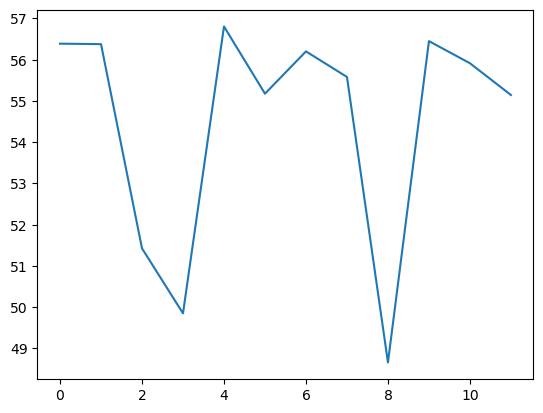

In [39]:
plt.plot(version2['Unit_cost'].values)
version2['Unit_cost'].values

array([55.7660659 , 57.00991654, 47.38039189, 47.32374028, 44.34669565,
       41.02620336, 41.45450108, 42.03993617, 43.30548339, 46.89522087,
       46.61255555, 44.32044994, 44.5044001 , 44.59460687, 46.61633889,
       45.84514121, 45.4568258 , 46.04351606, 44.86618053, 45.53773099,
       42.97896136, 46.28194906, 46.79948866])

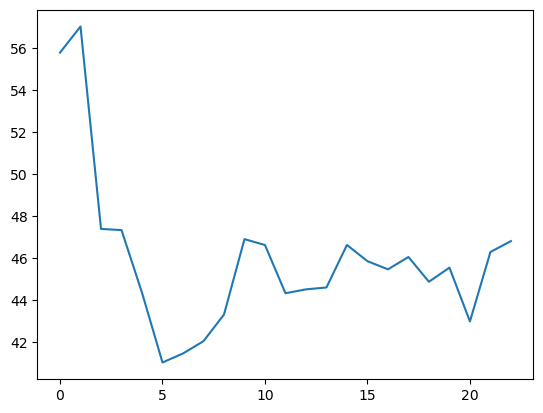

In [40]:
plt.plot(version3['Unit_cost'].values)
version3['Unit_cost'].values


In [43]:
# 假设我们有一些历史数据
history_time = np.arange(0, 23)  # 历史时间点
history_cost = version3['Unit_cost'].values  # 历史成本

# 定义未来时间
future_time = np.arange(0, 20)

# PyMC v4 模型
with pm.Model() as model:
    # 成本的先验：二次曲线（先降后升）
    alpha_cost = pm.Normal('alpha_cost', mu=0, sigma=10)  # 二次项
    beta_cost = pm.Normal('beta_cost', mu=0, sigma=10)  # 线性项
    gamma_cost = pm.Normal('gamma_cost', mu=70, sigma=10)  # 截距项，表示最低点大约在 70


    cost_pred = alpha_cost * history_time**2 + beta_cost * history_time + gamma_cost

    # 观察数据（历史数据作为观测值）
    cost_obs = pm.Normal('cost_obs', mu=cost_pred, sigma=5, observed=history_cost)
    

    # 定义未来的成本和价格预测为 Deterministic 变量
    future_cost_pred = pm.Deterministic('future_cost_pred', alpha_cost * future_time**2 + beta_cost * future_time + gamma_cost)

    # 后验采样
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_cost, beta_cost, gamma_cost]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 29 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [cost_obs]


Output()

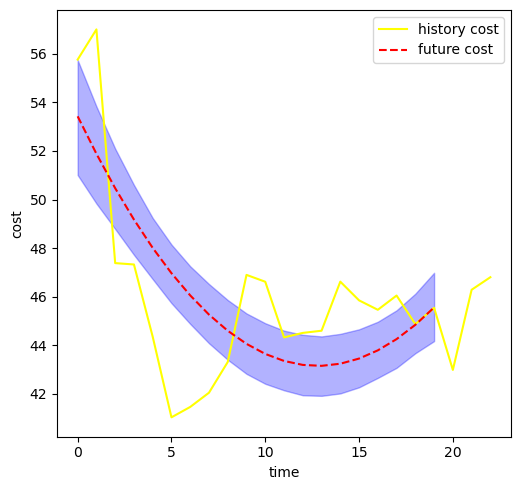

In [44]:
with model:
    # 获取未来的预测分布
    posterior_predictive = pm.sample_posterior_predictive(trace)

    # 提取未来的预测数据（从trace中提取）
    future_cost_samples = trace['posterior']['future_cost_pred']


# 预测结果可视化
plt.figure(figsize=(10, 5))

# 画出成本的预测
plt.subplot(1, 2, 1)
plt.plot(history_time, history_cost, 'yellow', label='history cost')
plt.plot(future_time, future_cost_samples.mean(axis=0).mean(axis = 0), 'r--', label='future cost')
plt.fill_between(future_time, 
                 np.percentile(future_cost_samples.mean(axis = 0), 5, axis=0), 
                 np.percentile(future_cost_samples.mean(axis = 0), 95, axis=0), 
                 color='blue', alpha=0.3)
plt.xlabel('time')
plt.ylabel('cost')
plt.legend()


plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

At x = 1, y = 13.062308310705268
At x = 2, y = 8.031594410594813
At x = 3, y = 6.205123577863922
At x = 4, y = 5.330568086834992
At x = 5, y = 4.806537234199825
At x = 6, y = 4.633121004604541
At x = 7, y = 4.741889326803464
At x = 8, y = 5.042987130990459
At x = 9, y = 5.80462194434767
At x = 10, y = 6.3422632425300165
At x = 11, y = 6.9895473033301405
At x = 12, y = 7.363444220042123


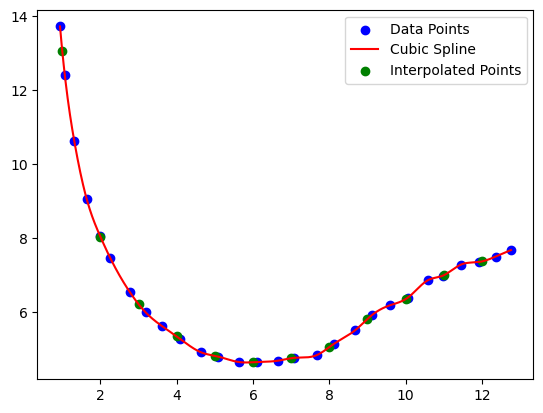

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# 假设你的数据已经存储在df中
df = pd.read_csv('cost_simu.csv')

# 从DataFrame中提取X和Y数据
X = df['X'].values
Y = df['Y'].values

# 使用样条插值
cs = CubicSpline(X, Y)

# 计算 x = 1, 2, 3, ..., 12 处的取值
x_values = np.arange(1, 13)
y_values = cs(x_values)

# 打印结果
for x, y in zip(x_values, y_values):
    print(f"At x = {x}, y = {y}")

# 可视化样条拟合曲线
plt.scatter(X, Y, color='blue', label='Data Points')  # 数据点
x_dense = np.linspace(min(X), max(X), 1000)  # 生成更密集的x值，用于绘制平滑曲线
y_dense = cs(x_dense)
plt.plot(x_dense, y_dense, color='red', label='Cubic Spline')  # 样条曲线
plt.scatter(x_values, y_values, color='green', label='Interpolated Points')  # 插值点
plt.legend()
plt.show()


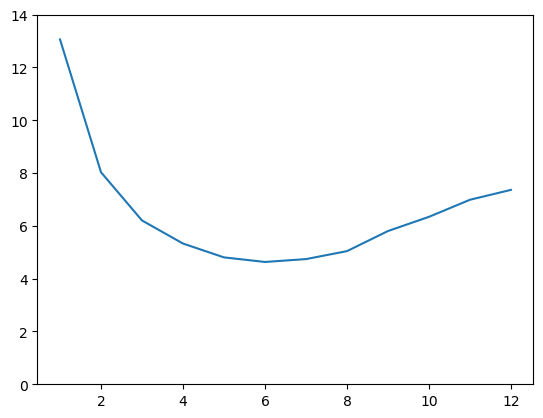

In [54]:
plt.ylim([0, 14])
plt.plot(x_values,y_values)
plt.show()

In [67]:
def ideal_KPI(mean_cost, mean_price):
    cost_base = np.array([13.06230831, 8.03159441, 6.20512358, 5.33056809, 4.80653723, 
                          4.633121, 4.74188933, 5.04298713, 5.80462194, 6.34226324, 6.9895473, 7.36344422])
    cost_mean = np.mean(cost_base)
    ideal_cost = cost_base +(mean_cost - cost_mean)
    slope = -4
    mean_price = 90  
    start_price = mean_price + (11 * 4) / 2
    months = np.arange(1, 13)
    ideal_price = start_price + slope * (months - 1)
    ideal_profit_rate = (ideal_price - ideal_cost)/ideal_price

    return ideal_price, ideal_cost, ideal_profit_rate

p, c, r = ideal_KPI(60, 100)

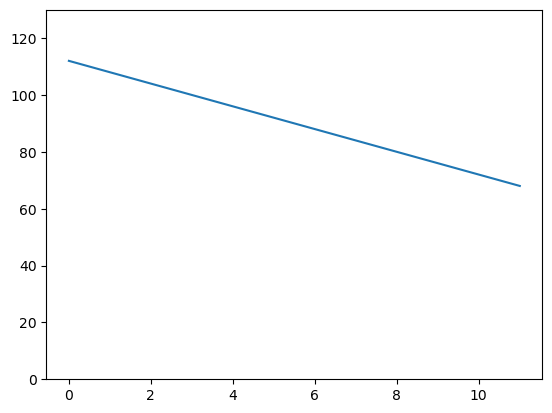

In [68]:
plt.ylim([0, 130])
plt.plot(p)


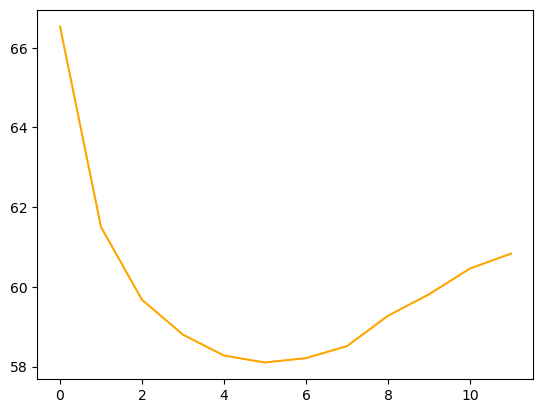

In [69]:
plt.plot(c, 'orange')

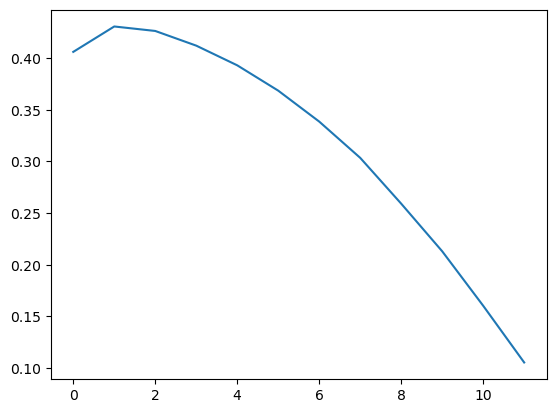

In [70]:
plt.plot(r)

## 2.
异常点检测｜

<Figure size 1000x600 with 0 Axes>

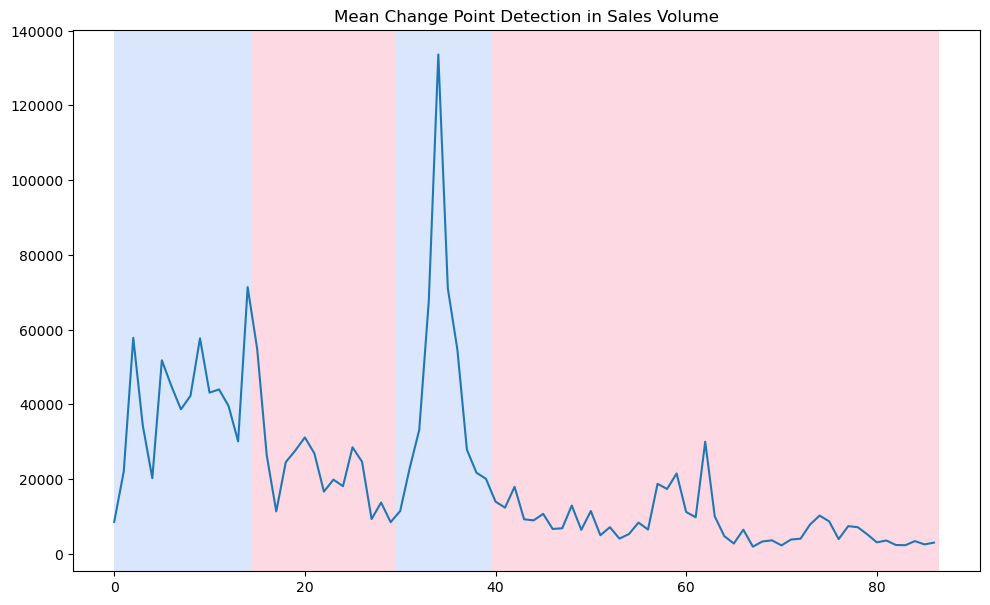

Mean change points: [15, 30, 40, 87]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

# Assuming your dataframe is named df and 'sales_volume' is the column with the sales data
# Let's also assume you have a datetime index or a time-related column

# If your 'df' doesn't have a datetime index, you can convert it, e.g.,:
# df['date'] = pd.to_datetime(df['date'])  # Make sure to replace 'date' with the actual date column name
# df.set_index('date', inplace=True)

# Perform seasonal decomposition to separate the trend, seasonal, and residual components
path = './../Dataset/latex_pillow.csv'
df = pd.read_csv(path)

# 假设df['sales_volume'] 是销售数据的时间序列
sales_volume = df['Sales_volume'].values

# 均值变点检测算法，使用binary segmentation (Binseg)
algo_mean = rpt.Binseg(model="l2").fit(sales_volume)

# 假设我们想要找出3个潜在的变点，n_bkps=3
result_mean = algo_mean.predict(n_bkps=3)

# 可视化均值变点
plt.figure(figsize=(10, 6))
rpt.show.display(sales_volume, result_mean, figsize=(10, 6))
plt.title("Mean Change Point Detection in Sales Volume")
plt.show()

# 打印变点的位置
print("Mean change points:", result_mean)



<Figure size 1000x600 with 0 Axes>

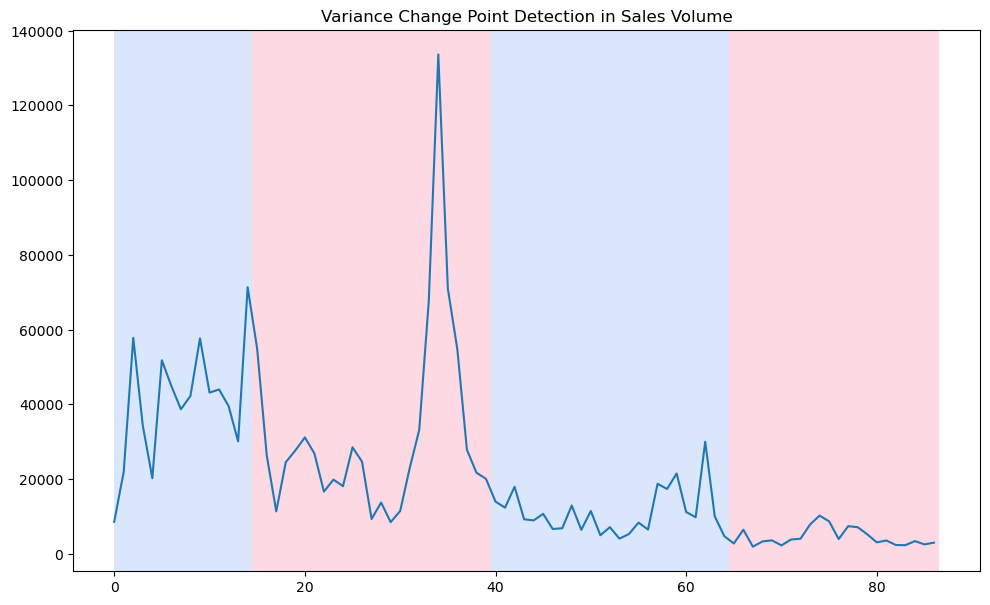

Variance change points: [15, 40, 65, 87]


In [9]:
# 方差变点检测算法，使用binary segmentation (Binseg)
algo_var = rpt.Binseg(model="rbf").fit(sales_volume)

# 假设我们想要找出3个潜在的变点，n_bkps=3
result_var = algo_var.predict(n_bkps=3)

# 可视化方差变点
plt.figure(figsize=(10, 6))
rpt.show.display(sales_volume, result_var, figsize=(10, 6))
plt.title("Variance Change Point Detection in Sales Volume")
plt.show()

# 打印变点的位置
print("Variance change points:", result_var)


/Users/tangning/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tangning/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 1000x600 with 0 Axes>

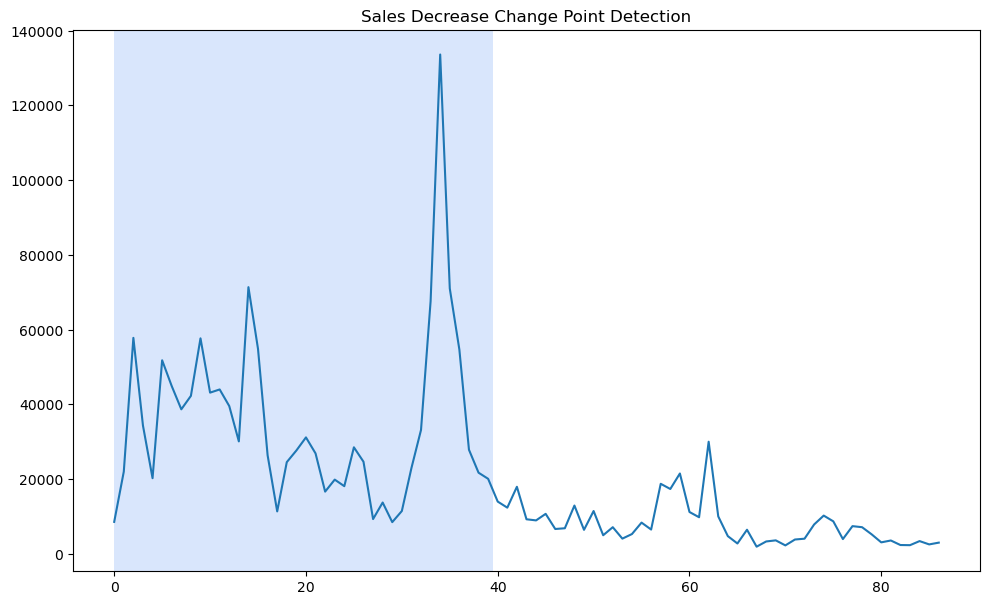

Sales decrease change points: [40]


In [10]:

# 假设df['sales_volume'] 是销售数据的时间序列
sales_volume = df['Sales_volume'].values

# 1. 使用均值变点检测算法（如 Binary Segmentation 或 Dynamic Programming）
algo = rpt.Binseg(model="l2").fit(sales_volume)

# 假设我们想检测3个变点
all_change_points = algo.predict(n_bkps=3)

# 2. 手动筛选出下降的变点
# 定义一个函数来判断变点前后的均值是否下降
def filter_decrease_points(series, change_points):
    decrease_points = []
    for i in range(1, len(change_points)):
        segment_before = series[change_points[i-1]:change_points[i]]
        segment_after = series[change_points[i]:change_points[i+1]] if i < len(change_points) - 1 else series[change_points[i]:]
        if np.mean(segment_before) > np.mean(segment_after):  # 如果均值减少
            decrease_points.append(change_points[i])
    return decrease_points

# 获得仅销量减少的变点
decrease_points = filter_decrease_points(sales_volume, all_change_points)

# 3. 可视化结果，仅显示销量减少的变点
plt.figure(figsize=(10, 6))
rpt.show.display(sales_volume, decrease_points, figsize=(10, 6))
plt.title("Sales Decrease Change Point Detection")
plt.show()

# 打印检测到的销量减少变点
print("Sales decrease change points:", decrease_points)



Analyzing KPI: Unit_cost
Change point 87 is out of bounds for column Unit_cost with window size 3


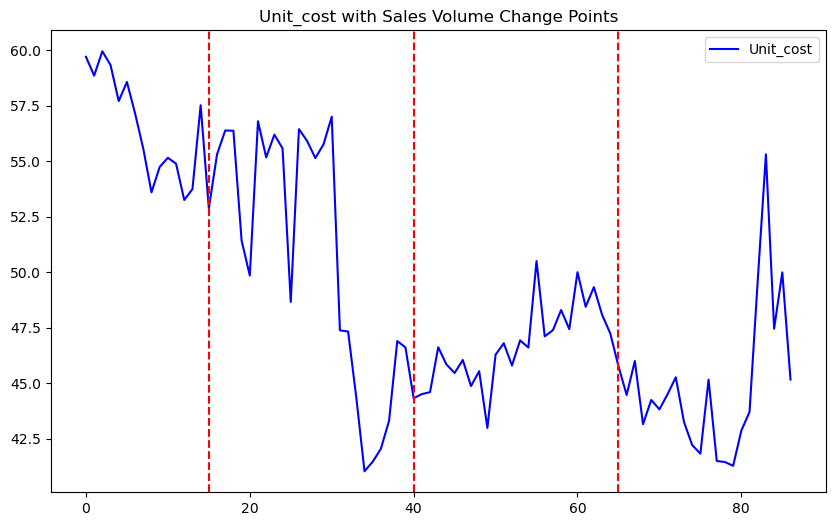


Analyzing KPI: Unit_price
Significant change detected at change point 15: 13.72%
Significant change detected at change point 40: 33.11%
Change point 87 is out of bounds for column Unit_price with window size 3


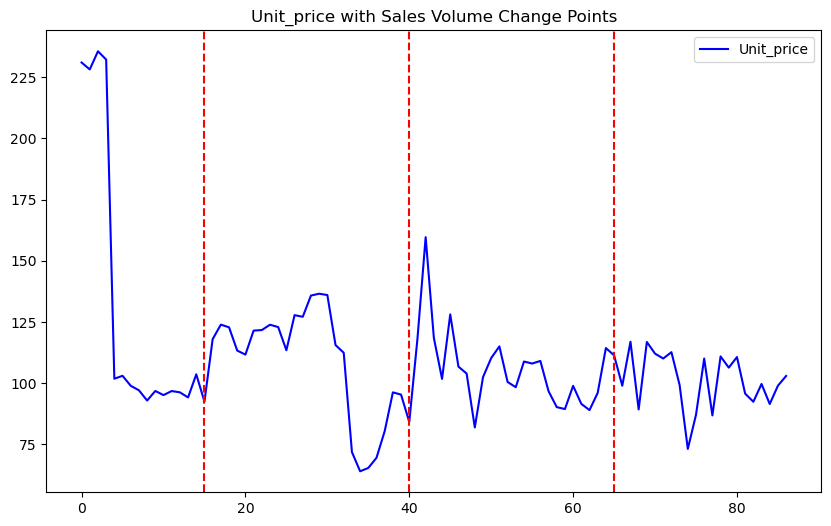


Analyzing KPI: Promotion_expense
Significant change detected at change point 15: -31.64%
Significant change detected at change point 40: -11.78%
Significant change detected at change point 65: -71.66%
Change point 87 is out of bounds for column Promotion_expense with window size 3


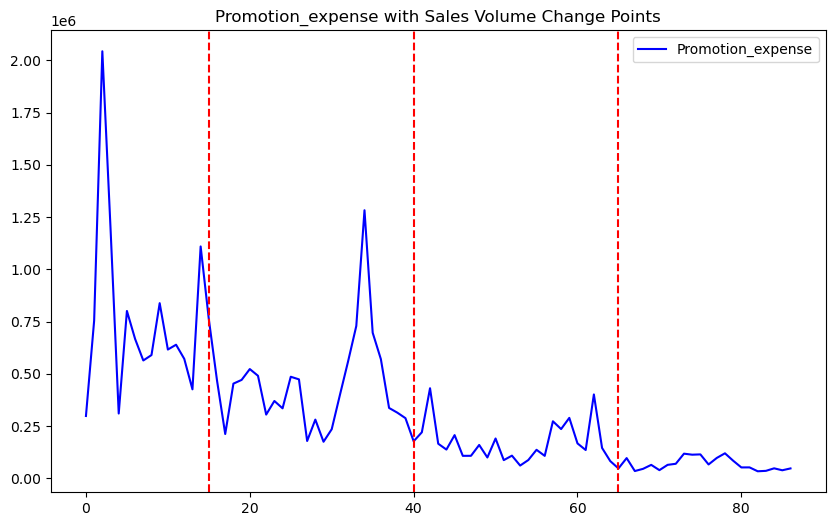


Analyzing KPI: Revenue
Significant change detected at change point 15: -31.64%
Significant change detected at change point 40: -11.78%
Significant change detected at change point 65: -71.66%
Change point 87 is out of bounds for column Revenue with window size 3


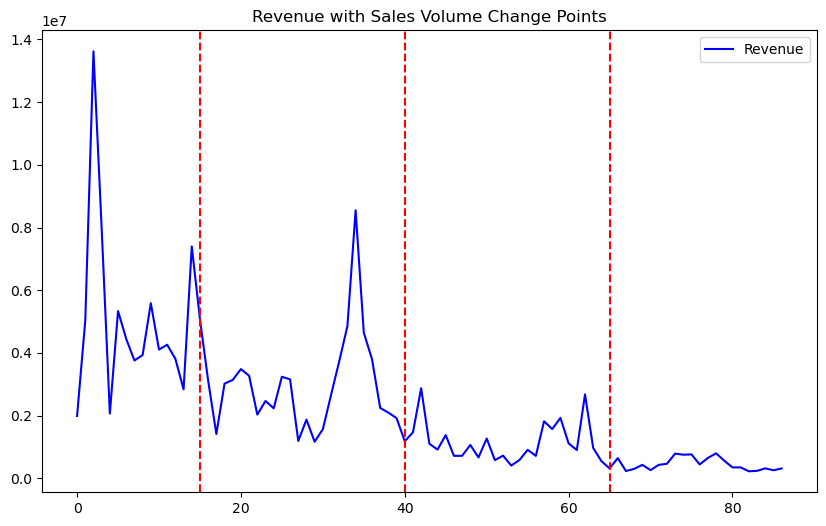


Analyzing KPI: ROI
Significant change detected at change point 15: 34.78%
Significant change detected at change point 40: 70.61%
Significant change detected at change point 65: 32.26%
Change point 87 is out of bounds for column ROI with window size 3


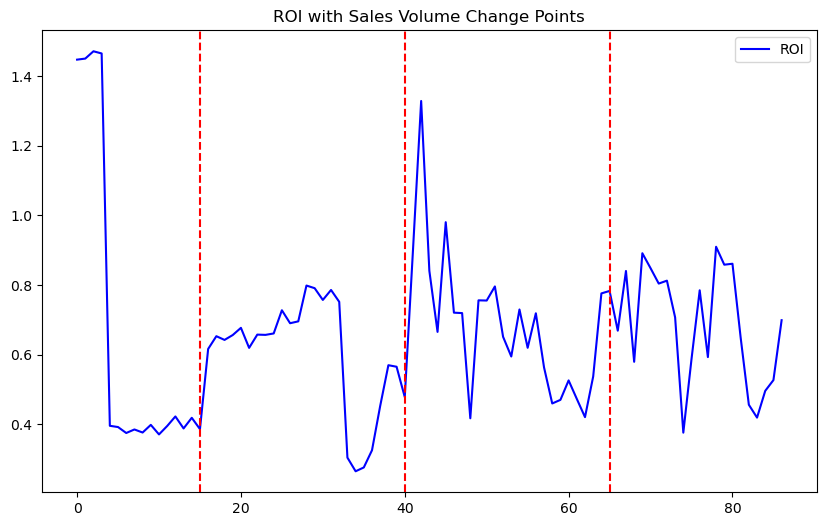

<Figure size 1000x600 with 0 Axes>

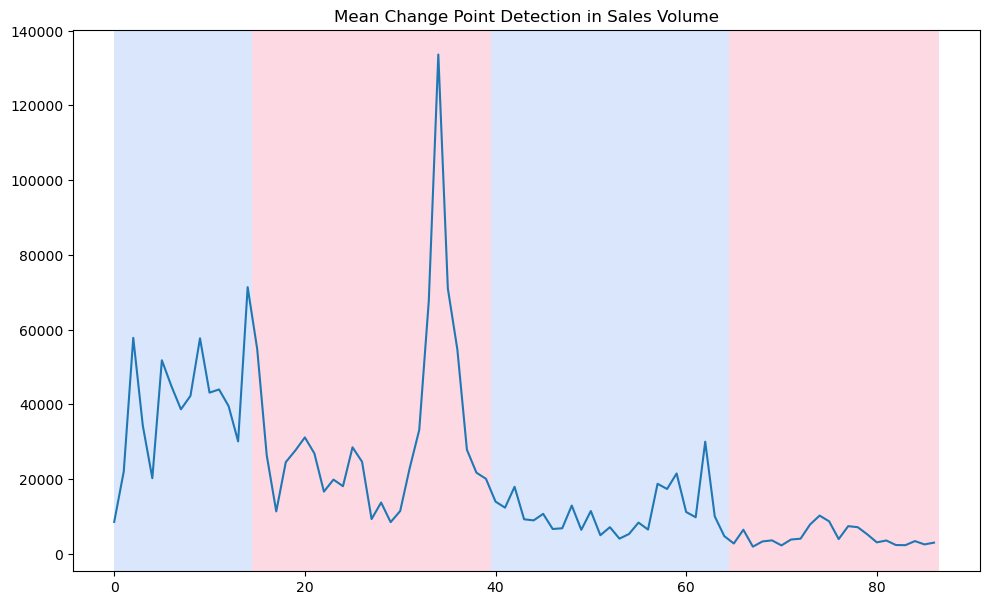

Change points in Sales_volume: [15, 40, 65, 87]

Summary of Significant KPI Changes:

KPI: Unit_price
 - Change point 15 with a 13.72% change.
 - Change point 40 with a 33.11% change.

KPI: Promotion_expense
 - Change point 15 with a -31.64% change.
 - Change point 40 with a -11.78% change.
 - Change point 65 with a -71.66% change.

KPI: Revenue
 - Change point 15 with a -31.64% change.
 - Change point 40 with a -11.78% change.
 - Change point 65 with a -71.66% change.

KPI: ROI
 - Change point 15 with a 34.78% change.
 - Change point 40 with a 70.61% change.
 - Change point 65 with a 32.26% change.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 滑动窗口大小
window_size = 3

# 比较KPI变化
KPI_columns = ['Unit_cost', 'Unit_price', 'Promotion_expense', 'Revenue', 'ROI']  # 假设这些是你关心的KPI列

# 获取 DataFrame 的长度
df_length = len(df)

# 定义显著变化的阈值（例如变化超过20%认为是显著变化）
change_threshold = 0.1

# 存储显著变化的KPI
significant_changes = {}

# 我们假设change_points已经通过对sales_volume的分析得出
# 例如: change_points = [15, 30, 40]
sales_volume = df['Sales_volume'].values

# 方差变点检测算法，使用binary segmentation (Binseg)
algo_var = rpt.Binseg(model="rbf").fit(sales_volume)

# 假设我们想要找出3个潜在的变点，n_bkps=3
change_points = algo_var.predict(n_bkps=3)



# 比较每个变点前后其他KPI的变化
for col in KPI_columns:
    print(f"\nAnalyzing KPI: {col}")
    
    # 创建一个字典来存储每个变点前后窗口的百分比变化
    kpi_changes = []

    for cp in change_points:
        if window_size <= cp < df_length - window_size:
            # 计算变点前后的滑动窗口均值
            window_before = df[col].iloc[cp - window_size:cp].mean()
            window_after = df[col].iloc[cp:cp + window_size].mean()
            
            # 计算变化百分比
            percentage_change = (window_after - window_before) / window_before
            
            kpi_changes.append({
                'change_point': cp,
                'before_mean': window_before,
                'after_mean': window_after,
                'percentage_change': percentage_change
            })
            
            # 检查是否超过变化阈值
            if abs(percentage_change) > change_threshold:
                print(f"Significant change detected at change point {cp}: {percentage_change * 100:.2f}%")
                
                # 将显著变化的KPI及对应变点存储
                if col not in significant_changes:
                    significant_changes[col] = []
                significant_changes[col].append({
                    'change_point': cp,
                    'percentage_change': percentage_change
                })
        else:
            print(f"Change point {cp} is out of bounds for column {col} with window size {window_size}")
    
    # 可视化KPI变化及变点
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[col], label=col, color='blue')
    
    for cp in change_points:
        if window_size <= cp < df_length - window_size:
            plt.axvline(x=cp, color='red', linestyle='--')
    
    plt.title(f'{col} with Sales Volume Change Points')
    plt.legend()
    plt.show()

# 输出总结：
plt.figure(figsize=(10, 6))
rpt.show.display(sales_volume, change_points, figsize=(10, 6))
plt.title("Mean Change Point Detection in Sales Volume")
plt.show()

# 打印变点的位置
print("Change points in Sales_volume:", change_points)
print("\nSummary of Significant KPI Changes:")
for col, changes in significant_changes.items():
    print(f"\nKPI: {col}")
    for change in changes:
        print(f" - Change point {change['change_point']} with a {change['percentage_change']*100:.2f}% change.")
